# Importing Franke's function, including a plot

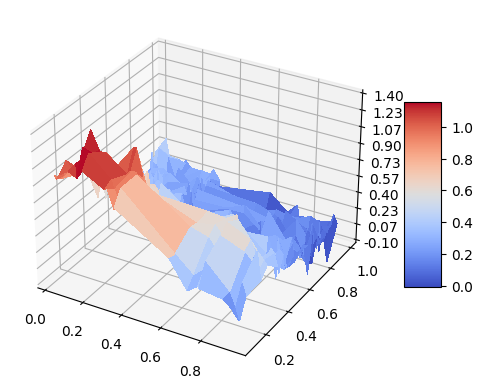

In [46]:
%reset -f

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, Normalize


# fixing the random seed for generating x, y as well as train_test_split
np.random.seed(467)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Generate the data
n = 20 # number of data points
x = np.random.rand(n)
y = np.random.rand(n)
x = np.sort(x)
y = np.sort(y)

x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y) + 0.1*np.random.normal(0,1, x.shape)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [47]:
def rsquare(y, ypredict):
    y = y.reshape(-1, 1)
    ypredict = ypredict.reshape(-1,1)
    return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))


def MSE(y_data,y_model):
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    y_model = y_model.reshape(-1, 1)
    return np.sum((y_data-y_model)**2)/n

## a) Ordinary Least Squares

The optimal polynomial degree is 6 with a test MSE of 0.010611212614067422
best MSE train: 0.009426392517985754, at pol degree: 8


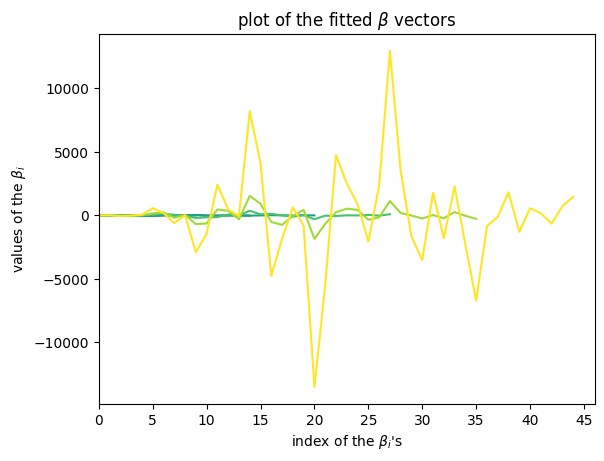

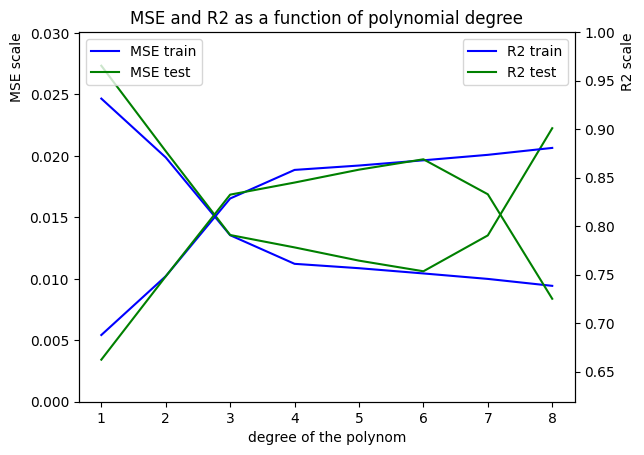

In [48]:
# max degree of the fitted polynomial
degree = 8

# setting up the Designmatrix
x = x.reshape(-1,1) #reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)

# credit: M. Hjorth-Jensen: Weekly Material, Week 35
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

X = create_X(x,y,degree)

X = X[:, 1:]

# splitting in train and test data
X_train, X_test, z_train, z_test = train_test_split( X, z, test_size=0.33, random_state=42)

# scaling the data, in this case we only center the data, thus we subtract the mean values from each column from every column entry
# we now calculate our OLS model's intercept by using the expression from the lecture notes (M. Hjorth-Jensen: Notes on scaling with examples), which results from deriving the cost/loss function by beta0 and setting it to zero
# since our cost/loss function is convex this leads us to finding its minimum with respect to beta0
# The model intercept follows the equation z_scaler = np.mean(z_train) - np.mean(X_train_sc) * beta. Since we above centered our Designmatrix, the mean vector of X_train_sc equals the zero vector. Our equation reduces to:

X_train_mean = np.mean(X_train,axis=0)
X_train_scaled = X_train - X_train_mean
X_test_scaled = X_test - X_train_mean
z_scaler = np.mean(z_train)  
# We now center our z data
z_train_scaled = z_train - z_scaler
z_test_scaled = z_test - z_scaler

# OLS fitting

beta_list = []
MSE_train = np.zeros(degree)
MSE_test = np.zeros(degree)
rsqr_train = np.zeros(degree)
rsqr_test = np.zeros(degree)


for i in range(1, degree+1):
    c = int((i+2)*(i+1)/2)
    X_tilde = X_train_scaled[:,0:c-1]
    beta = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ z_train_scaled

    beta_list.append(list(beta))
		
    ypredict = X_tilde @ beta
    ypredict_test = X_test_scaled[:,0:c-1] @ beta

    MSE_train[i-1] = MSE(z_train_scaled, ypredict)
    MSE_test[i-1] = MSE(z_test_scaled, ypredict_test)
    rsqr_train[i-1]= rsquare(z_train_scaled, ypredict)
    rsqr_test[i-1]= rsquare(z_test_scaled, ypredict_test)

# plotting the MSE and R^2 - as well as beta - as functions of the polynomial degree
fig = plt.figure()

fig2, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, degree +1)
plt.xticks(xax)
ax2 = ax1.twinx()
ax2.set_ylim(np.min(rsqr_train)*0.9, 1)
ax1.set_ylim(0, np.max(MSE_test)*1.1)
ax1.plot(xax, MSE_train, 'b-', label='MSE train')
ax1.plot(xax, MSE_test, 'g-', label='MSE test')
ax2.plot(xax, rsqr_train, 'b-', label='R2 train')
ax2.plot(xax, rsqr_test, 'g-', label='R2 test')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('MSE scale', loc='top')
ax2.set_ylabel('R2 scale', loc='top')
plt.title('MSE and R2 as a function of polynomial degree')

# plot the beta

fig3 = fig.subplots()
xax2 = np.arange(0, len(X)+2, 5)
fig3.set_xticks(xax2)
fig3.set_xlim(0, X.shape[1]+2)
beta_list = np.nan_to_num(beta_list)
colors = plt.cm.viridis(np.linspace(0, 1, degree))
for i in range(len(beta_list)):
	fig3.plot(np.append(z_scaler, beta_list[i]), color=colors[i])
fig3.set_ylabel("values of the " + r'$\beta_i$')
fig3.set_xlabel("index of the " + r'$\beta_i$' + "'s")
fig3.set_title("plot of the fitted " + r'$\beta$' + " vectors")


MSE_opt_OLS , para_opt_OLS = MSE_test.min(), MSE_test.argmin()
print("The optimal polynomial degree is "+str(para_opt_OLS+1)+" with a test MSE of "+str(MSE_opt_OLS))
MSE_mintrain_OLS, para_mintrain_OLS = MSE_train.min(), MSE_train.argmin()
print("best MSE train: "+str(MSE_mintrain_OLS)+", at pol degree: "+str(para_mintrain_OLS+1))

# b) Ridge regression

The optimal parameters are [lambda, polynomial degree] = [1e-05, 8] with a test MSE of 0.010737430818244345
best MSE train: 0.010593933208474625, at [lambda, polynomial degree] = [1e-05, 8]


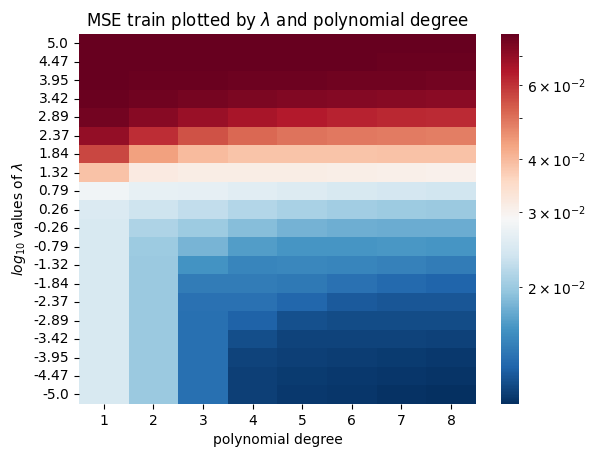

In [49]:
# We are using the same data, as well as splitting, as in a). This allows us a better comparison between our results from the OLS and the Ridge fitting.

lmb = np.logspace(-5, 5, 20) 

MSE_train_Ridge = np.zeros((len(lmb),degree))
MSE_test_Ridge = np.zeros((len(lmb),degree))
rsqr_train_Ridge = np.zeros((len(lmb),degree))
rsqr_test_Ridge = np.zeros((len(lmb),degree))

beta_Ridge = []

for j in range(len(lmb)):
    for i in range(1, degree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = X_train_scaled[:,0:c-1]
            beta = np.linalg.pinv(X_tilde.T @ X_tilde + lmb[j]*np.eye(len(X_tilde.T))) @ X_tilde.T @ z_train_scaled
            
            beta_Ridge.append(beta)

            ypredict = X_tilde @ beta
            ypredict_test = X_test_scaled[:,0:c-1] @ beta

            MSE_train_Ridge[j, i-1] = MSE(z_train_scaled, ypredict)
            MSE_test_Ridge[j, i-1] = MSE(z_test_scaled, ypredict_test)
            rsqr_train_Ridge[j, i-1]= rsquare(z_train_scaled, ypredict)
            rsqr_test_Ridge[j, i-1]= rsquare(z_test_scaled, ypredict_test)


# plotting the MSEs as functions of the polynomial degree
lmb_labels = np.log10(lmb).round(2)
df_MSE_train_Ridge = pd.DataFrame(MSE_train_Ridge, index=lmb_labels, columns=np.arange(1, degree+1))
df_MSE_train_Ridge = df_MSE_train_Ridge.iloc[::-1, :]
df_MSE_test_Ridge = pd.DataFrame(MSE_test_Ridge, index=lmb_labels, columns=np.arange(1, degree+1))
df_MSE_test_Ridge = df_MSE_test_Ridge.iloc[::-1, :]

minimum = [MSE_test_Ridge.min(), MSE_train_Ridge.min()]
min = np.min(minimum)
maximum = [MSE_test_Ridge.max(), MSE_train_Ridge.max()]
max = np.max(maximum)

fig = sns.heatmap(df_MSE_train_Ridge, norm=LogNorm(), cmap='RdBu_r', vmin=min, vmax=max)
fig.set(xlabel="polynomial degree", ylabel=r'$log_{10}$'+" values of "+r'$\lambda$', title="MSE train plotted by "+r'$\lambda$'+" and polynomial degree")


MSE_opt_Ridge, para_opt_Ridge = MSE_test_Ridge.min(), np.unravel_index(MSE_test_Ridge.argmin(), MSE_test_Ridge.shape)
print("The optimal parameters are [lambda, polynomial degree] = ["+str(lmb[para_opt_Ridge[0]])+", "+str(para_opt_Ridge[1]+1)+"]"+" with a test MSE of "+str(MSE_test_Ridge.min()))
MSE_mintrain_Ridge, para_mintrain_Ridge = MSE_train_Ridge.min(), np.unravel_index(MSE_train_Ridge.argmin(), MSE_train_Ridge.shape)
print("best MSE train: "+str(MSE_mintrain_Ridge)+", at [lambda, polynomial degree] = ["+str(lmb[para_mintrain_Ridge[0]])+", "+str(para_mintrain_Ridge[1]+1)+"]")

[Text(0.5, 23.52222222222222, 'polynomial degree'),
 Text(50.722222222222214, 0.5, '$log_{10}$ values of $\\lambda$'),
 Text(0.5, 1.0, 'MSE test plotted by $\\lambda$ and polynomial degree')]

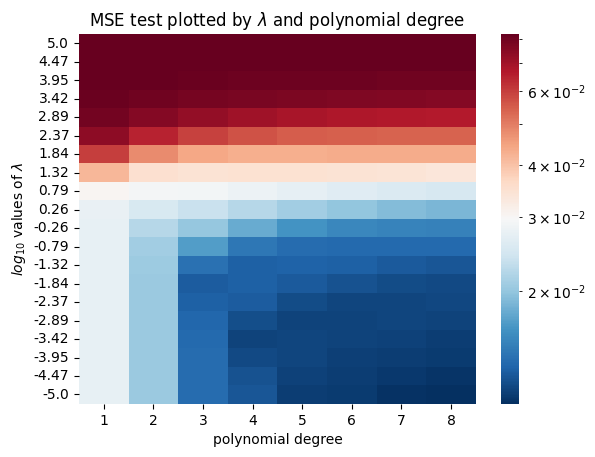

In [50]:
fig2 = sns.heatmap(df_MSE_test_Ridge, norm=LogNorm(), cmap='RdBu_r', vmin=min, vmax=max)
fig2.set(xlabel="polynomial degree", ylabel=r'$log_{10}$'+" values of "+r'$\lambda$', title="MSE test plotted by "+r'$\lambda$'+" and polynomial degree")

# c) Lasso Regression

The optimal parameters are [lambda, polynomial degree] = [3.359818286283781e-05, 6] with a test MSE of 0.011641822246688631
best MSE train: 0.011145036665796935, at [lambda, polynomial degree] = [1e-05, 5]


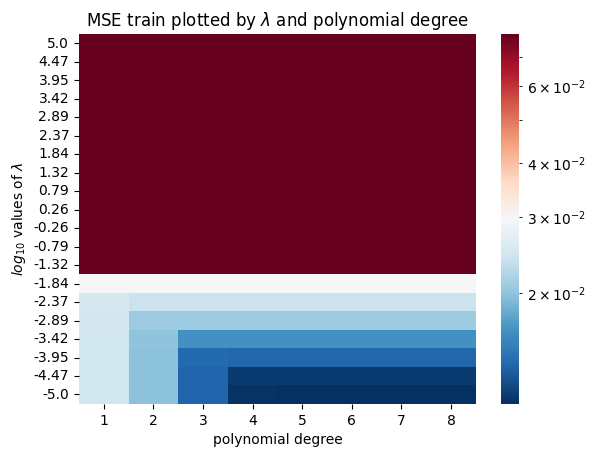

In [51]:

MSE_train_Lasso = np.zeros((len(lmb),degree))
MSE_test_Lasso = np.zeros((len(lmb),degree))
rsqr_train_Lasso = np.zeros((len(lmb),degree))
rsqr_test_Lasso = np.zeros((len(lmb),degree))

X_tilde = X_train_scaled[:,[0, 1]]
# we can only fit the Lasso Reg without an intercept, when we can assure that the calculated intercept would equal zero, that's why we also scaled z above.

beta_Lasso = []

for j in range(len(lmb)):
    for i in range(1, degree+1):
        
        poly = PolynomialFeatures(degree=i)
        designmatrix = poly.fit_transform(X_tilde)
        RegLasso = linear_model.Lasso(lmb[j],fit_intercept=False)
        RegLasso.fit(designmatrix,z_train_scaled)

        beta_Lasso.append(RegLasso.intercept_)
        beta_Lasso.append(RegLasso.coef_)

        ypredict_Lasso = RegLasso.predict(designmatrix)
        ypredict_test_Lasso = RegLasso.predict(poly.fit_transform(X_test_scaled[:,[0, 1]]))

        MSE_train_Lasso[j, i-1] = MSE(z_train_scaled, ypredict_Lasso)
        MSE_test_Lasso[j, i-1] = MSE(z_test_scaled, ypredict_test_Lasso)
        rsqr_train_Lasso[j, i-1] = MSE(z_train_scaled, ypredict_Lasso)
        rsqr_test_Lasso[j, i-1] = MSE(z_test_scaled, ypredict_test_Lasso)
        

# plotting the MSE and R^2 - as well as beta - as functions of the polynomial degree
minimum = [MSE_test_Lasso.min(), MSE_train_Lasso.min()]
min = np.min(minimum)
maximum = [MSE_test_Lasso.max(), MSE_train_Lasso.max()]
max = np.max(maximum)

df_MSE_train_Lasso = pd.DataFrame(MSE_train_Lasso, index=lmb_labels, columns=np.arange(1, degree+1))
df_MSE_train_Lasso = df_MSE_train_Lasso.iloc[::-1, :]
df_MSE_test_Lasso = pd.DataFrame(MSE_test_Lasso, index=lmb_labels, columns=np.arange(1, degree+1))
df_MSE_test_Lasso = df_MSE_test_Lasso.iloc[::-1, :]

fig = sns.heatmap(df_MSE_train_Lasso, norm=LogNorm(), cmap='RdBu_r', vmin=min, vmax=max)
fig.set(xlabel="polynomial degree", ylabel=r'$log_{10}$'+" values of "+r'$\lambda$', title="MSE train plotted by "+r'$\lambda$'+" and polynomial degree")


MSE_opt_Lasso, para_opt_Lasso = MSE_test_Lasso.min(), np.unravel_index(MSE_test_Lasso.argmin(), MSE_test_Lasso.shape)
MSE_mintrain_Lasso, para_mintrain_Lasso = MSE_train_Lasso.min(), np.unravel_index(MSE_train_Lasso.argmin(), MSE_train_Lasso.shape)
print("The optimal parameters are [lambda, polynomial degree] = ["+str(lmb[para_opt_Lasso[0]])+", "+str(para_opt_Lasso[1]+1)+"]"+" with a test MSE of "+str(MSE_test_Lasso.min()))
print("best MSE train: "+str(MSE_mintrain_Lasso)+", at [lambda, polynomial degree] = ["+str(lmb[para_mintrain_Lasso[0]])+", "+str(para_mintrain_Lasso[1]+1)+"]")

[Text(0.5, 23.52222222222222, 'polynomial degree'),
 Text(50.722222222222214, 0.5, '$log_{10}$ values of $\\lambda$'),
 Text(0.5, 1.0, 'MSE test plotted by $\\lambda$ and polynomial degree')]

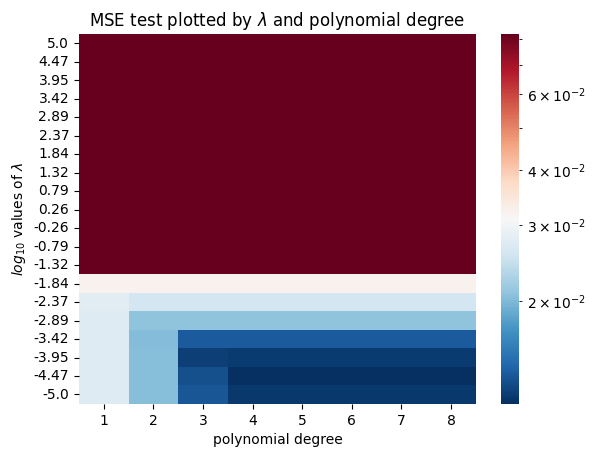

In [52]:
fig2 = sns.heatmap(df_MSE_test_Lasso, norm=LogNorm(), cmap='RdBu_r', vmin=min, vmax=max)
fig2.set(xlabel="polynomial degree", ylabel=r'$log_{10}$'+" values of "+r'$\lambda$', title="MSE test plotted by "+r'$\lambda$'+" and polynomial degree")

Text(0.5, 0, '$log_{10}$ values of $\\lambda$')

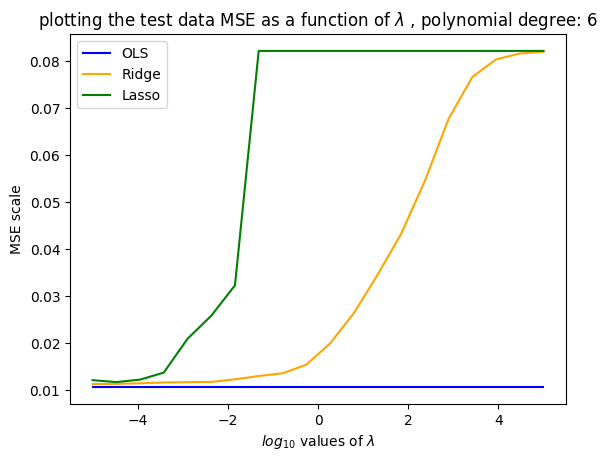

In [53]:
glob_min = np.min([MSE_opt_OLS, MSE_opt_Ridge, MSE_opt_Lasso])
glob_argmin = np.argmin([MSE_opt_OLS, MSE_opt_Ridge, MSE_opt_Lasso])

if glob_argmin == 0:
    para_opt = para_opt_OLS
elif glob_argmin == 1:
    para_opt = para_opt_Ridge[1]
elif glob_argmin == 2:
    para_opt = para_opt_Lasso[1]

plt.figure()
plt.title("plotting the test data MSE as a function of " + r'$\lambda$' + " , polynomial degree: "+str(para_opt+1))
plt.plot(np.log10(lmb), np.ones(len(lmb))*MSE_test[para_opt], 'b-', label='OLS')
plt.plot(np.log10(lmb), MSE_test_Ridge[:, para_opt], 'orange', label='Ridge')
plt.plot(np.log10(lmb), MSE_test_Lasso[:, para_opt], 'g-', label='Lasso')
plt.legend()
plt.ylabel('MSE scale')
plt.xlabel(r'$log_{10}$'+' values of '+r'$\lambda$')